# Intel Image Classififcation CNN 
## Convolutional Neural Netowrk

### Table of contents

1. Imports 
2. Paths 
3. Load and transform images
- 3.1 Load images to training and testing data sets
- 3.2 Exploration of the dataset
4. Visualize the data
5. Create and train model
- 5.1 Layers
- 5.2 Compile the model
6. Analyze model
-6.1 Plot the accuracy and training loss
- 6.2 Predictions on random images from the trianed model
- 6.3 Analyze and display mislabeled images
- 6.4 Probability and accuracy
- 6.4.1 Images from the datasets
- 6.4.2 Our images


### 1. Imports

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import tensorflow.keras.utils as image2
from keras.applications.vgg16 import preprocess_input
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn import metrics

### 2. Paths

In [2]:
CURR_DIR_PATH = os.getcwd()

# Training paths
seg_train_path = CURR_DIR_PATH + "//data//seg_train//seg_train"

train_forest_path = seg_train_path + "//forest"
train_buildings_path = seg_train_path + "//buildings"
train_glacier_path = seg_train_path + "//glacier"
train_mountain_path = seg_train_path + "//mountain"
train_sea_path = seg_train_path + "//sea"
train_street_path = seg_train_path + "//street"

# Test paths
seg_test_path = CURR_DIR_PATH + "//data//seg_test//seg_test"

test_forest_path = seg_test_path + "//forest"
test_buildings_path = seg_test_path + "//buildings"
test_glacier_path = seg_test_path + "//glacier"
test_mountain_path = seg_test_path + "//mountain"
test_sea_path = seg_test_path + "//sea"
test_street_path = seg_test_path + "//street"

# Prediction path

seg_pred_path = CURR_DIR_PATH + "//data//seg_pred//seg_pred"

# Our path

seg_our_path = CURR_DIR_PATH + "//data//seg_our//seg_our"

### 3. Load and transform images

In [3]:
def load_data(paths):
    images = []
    labels = []
    label = -1
    for path in paths:
        label = label+1
        for file in tqdm(os.listdir(path)):
            image_path = os.path.join(path, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(150, 150)) 
            image = image/ 255.0
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    output = (images,labels)
    return output

3.1 Load images to training and testing data sets

In [4]:
train_paths = [train_buildings_path, train_forest_path, train_glacier_path, train_mountain_path, train_sea_path, train_street_path]
test_paths = [test_buildings_path, test_forest_path, test_glacier_path, test_mountain_path, test_sea_path, test_street_path]
train_images, train_labels= load_data(train_paths)
print (f"Number of training images: {train_labels.shape[0]}")
test_images, test_labels = load_data(test_paths)
print (f"Number of testing images: {test_labels.shape[0]}")

100%|██████████| 2382/2382 [00:04<00:00, 477.11it/s]


Number of training images: 14034


100%|██████████| 501/501 [00:01<00:00, 451.08it/s]


Number of testing images: 3000


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

3.2 Exploration of the dataset

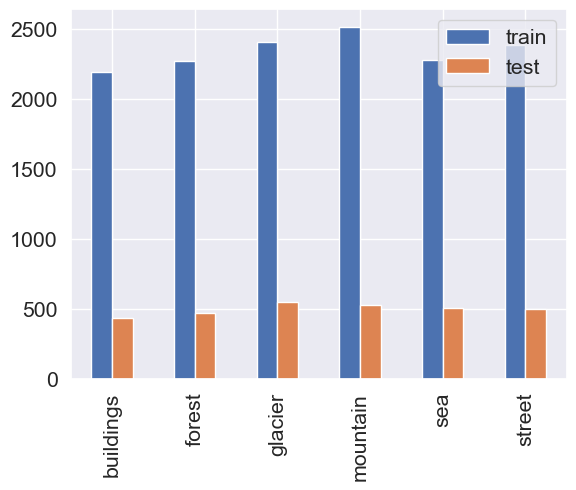

In [6]:
category_label=['buildings','forest', 'glacier','mountain','sea','street']
train_counts =[2191,2271,2404,2512,2274,2382]
test_counts = [437,474,553,525,510,501]
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=category_label
            ).plot.bar()
plt.show()

Proportions for train images

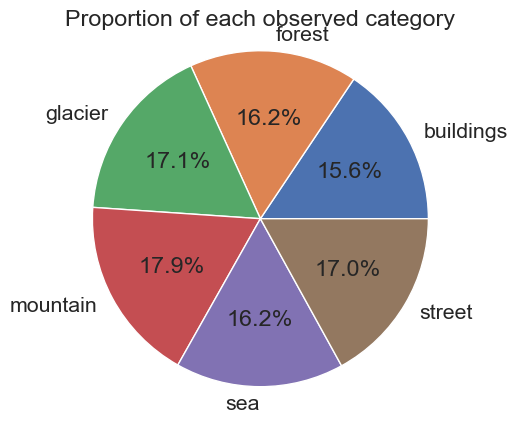

In [7]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=category_label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

Proportion for test images

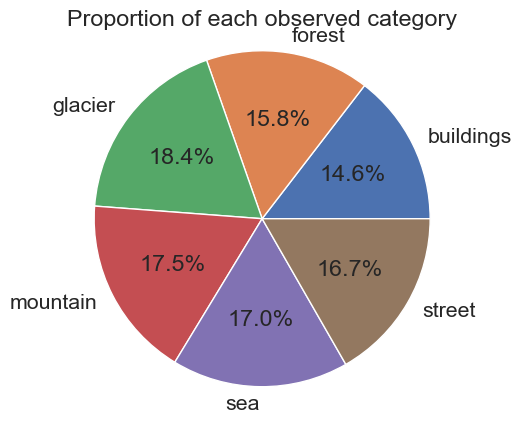

In [8]:
plt.pie(test_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=category_label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

### 4. Visualize the data
We can display a random image from the training set.

In [24]:
def display_random_image(category_label, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f'Image #{index} : {category_label[labels[index]]} ')
    plt.show()

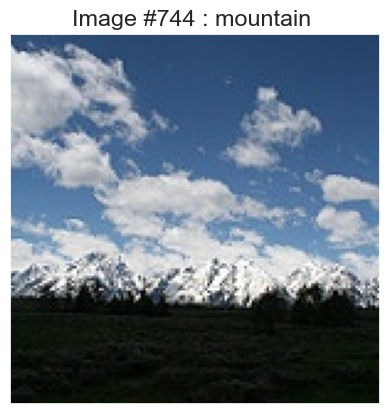

In [25]:
display_random_image(category_label, train_images, train_labels)

We can also display the first 25 images from the training set directly with a loop to get a better view

In [11]:
def display_examples(category_label, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(category_label[labels[i]])
    plt.show()

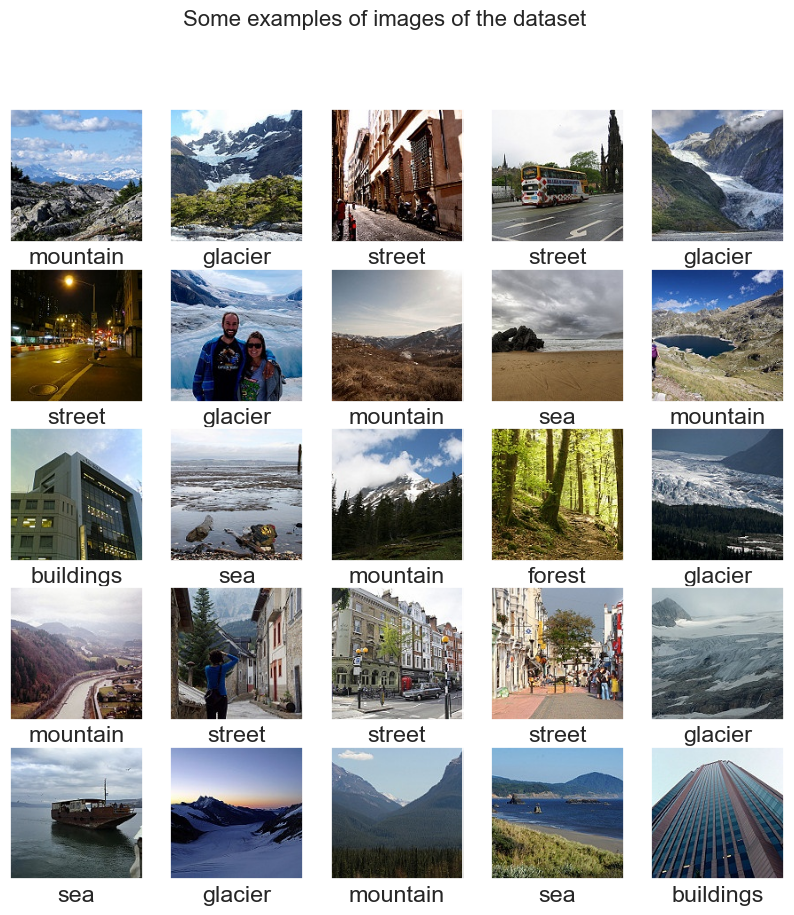

In [26]:
display_examples(category_label, train_images, train_labels)

### 5. Create and train model

5.1 Layers

We add layers to the model with values/specifications that fits our images.

Conv2D: We set 32 filters of kernel size (3x3) which is the most commonly used. This layer creates a convolution kernel (32 filters) that produces a set of feature maps.

MaxPooling2D: W edown-sample the input data into a pool size of (2,2), which means the output of this layer will have half the spatial resolution of the inputs.

Flatten: This converts our input tensor from a 2D tensor into 1D (dimension). 

Dense: This is a connect layer, it tasks a 1D input tensor and applies a set of weights and biases to compute a single output value for each element in the tensor (usually comes at the end, after we flatten the tensor into 1D).


In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

5.2 Compile the model

The compile method configures the learning process of the model.

optimizer: 'adam' is a popular gradient-based optimization algorithm.

loss: this is used to evaluate the models performance during training.

metrics: We specify the metrics that will be used to evaluate the models performance. 'Accuracy' measures the fraction of correctly classified samples.


In [28]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

5.3 Fit/train model

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

We can achieve difference results by adjusting 'batch_size' and 'epochs'. 

In [29]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=4, validation_split = 0.2)

Epoch 1/4
88/88 [==============================] - 133s 1s/step - loss: 1.1266 - accuracy: 0.5633 - val_loss: 0.8495 - val_accuracy: 0.6658
Epoch 2/4
88/88 [==============================] - 141s 2s/step - loss: 0.7238 - accuracy: 0.7336 - val_loss: 0.7445 - val_accuracy: 0.7346
Epoch 3/4
88/88 [==============================] - 142s 2s/step - loss: 0.5689 - accuracy: 0.7985 - val_loss: 0.7021 - val_accuracy: 0.7496
Epoch 4/4
88/88 [==============================] - 133s 2s/step - loss: 0.4612 - accuracy: 0.8371 - val_loss: 0.5900 - val_accuracy: 0.7870


### 6. Analyze model

6.1 Plot the accuracy and training loss

In [30]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

Inspect the keys from our model

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plot the result of accuracy and loss

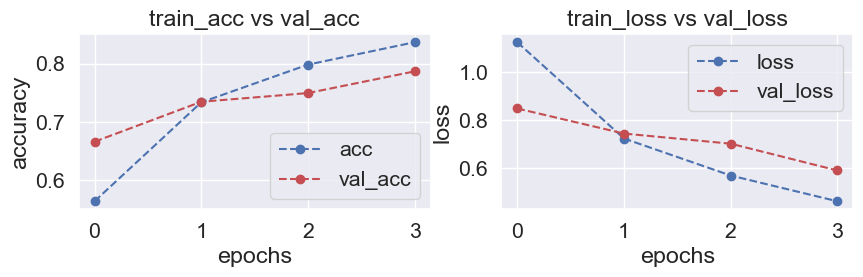

In [32]:
plot_accuracy_loss(history)

We evaluate the models performance on test set

In [33]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 9s 94ms/step - loss: 0.5896 - accuracy: 0.7883


6.2 Predictions on random images from the trianed model

94/94 [==============================] - 9s 93ms/step


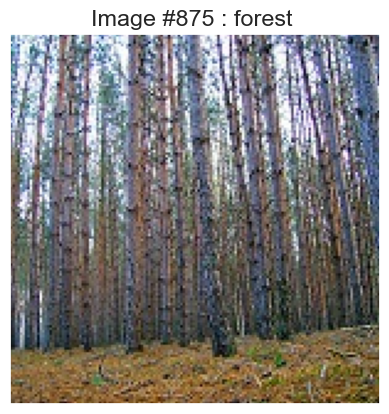

In [34]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(category_label, test_images, pred_labels)

6.3  Analyze and display mislabeled images

We can try to detect and analyze which images was most difficult to classify.

In [35]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
 
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels) 


We can change the number of images we want to look at by changing range from the function 'display_examples'.

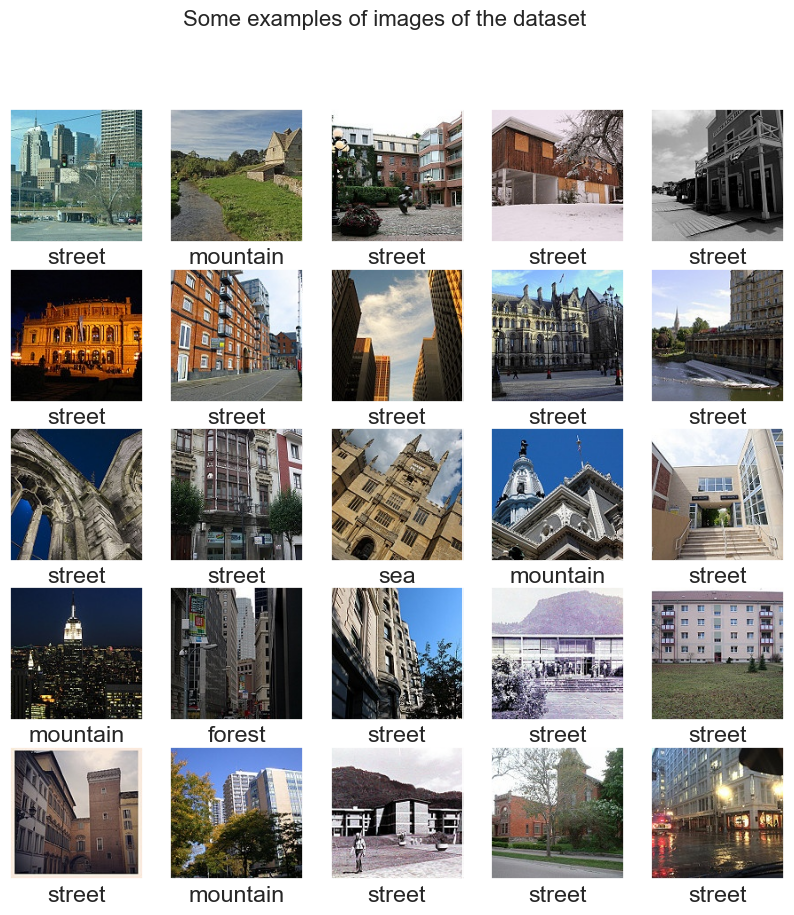

In [36]:
print_mislabeled_images(category_label, test_images, test_labels, pred_labels)

Further analysis of what images was difficult to label/classify. The confusion matrix illustrates this.

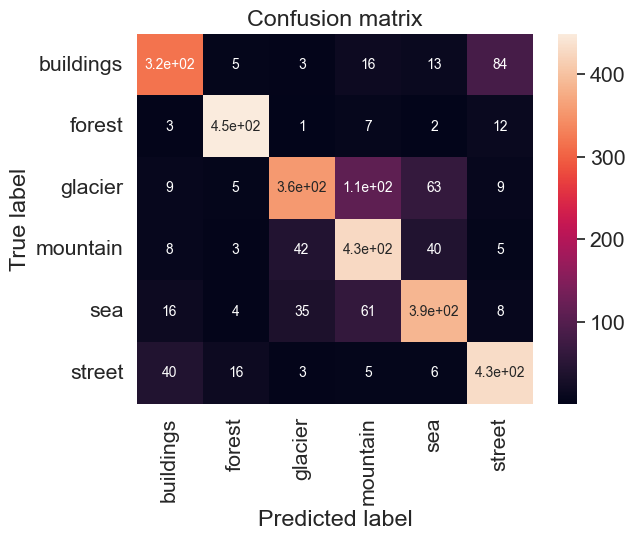

In [37]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=category_label, 
           yticklabels=category_label, ax = ax)
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

In [38]:
# KVAR:
# CLASSIFICATION REPORT
# EGNA BILDER 

In [39]:
#from sklearn import metrics
y_pred = model.predict(test_images)
print(y_pred) # se till att den endast tar ett prediction value //André
#print(metrics.classification_report(test_labels, y_pred, target_names=category_label))

94/94 [==============================] - 8s 90ms/step
[[8.7206841e-01 7.6020251e-06 3.5082575e-02 4.5802314e-02 4.4390716e-02
  2.6484227e-03]
 [2.7016464e-01 1.7080117e-02 1.4399433e-02 2.4887865e-02 1.6917069e-02
  6.5655082e-01]
 [9.3988270e-01 6.6480578e-05 2.4508988e-04 6.5032900e-03 7.4908361e-03
  4.5811728e-02]
 ...
 [4.3569382e-02 2.2944018e-04 4.8040595e-02 8.0632156e-01 1.0113892e-01
  7.0016726e-04]
 [8.9455563e-01 9.5611409e-05 1.8278124e-04 7.2222331e-04 2.0626320e-02
  8.3817452e-02]
 [6.6260360e-02 6.5185977e-03 3.4159944e-05 2.9076809e-05 1.0549826e-04
  9.2705232e-01]]


6.4 Probability and accuracy

We display the probability that the model has concluded for each of the six classes/categories, on different images.    

In [40]:
def processing(path):
    img = cv2.imread(path)
    test1_proc = image2.load_img(path , target_size=(150,150))
    test1_proc_1 = image2.img_to_array(test1_proc)
    t1 = np.expand_dims(test1_proc ,axis=0)
    t1 = t1/255
    pred_classes = model.predict(t1)
    pred = np.argmax(pred_classes ,axis=1)

    plt.subplot(121)
    pic = Image.open(path) 
    plt.xlabel("Original Image")
    plt.imshow(pic)
    
    
    plt.subplot(122)

    s1 = pd.Series(pred_classes.ravel() , index = category_label)
    s1.plot(kind = 'bar' ,figsize = (10,5))
    plt.xlabel("prediction")
    
    plt.show()

    #for i in training_image.class_indices:
    #    if pred == training_image.class_indices[i]:
    #        print("prediction made by model is :" ,i)

6.4.1 Images from the datasets

1/1 [==============================] - 0s 34ms/step


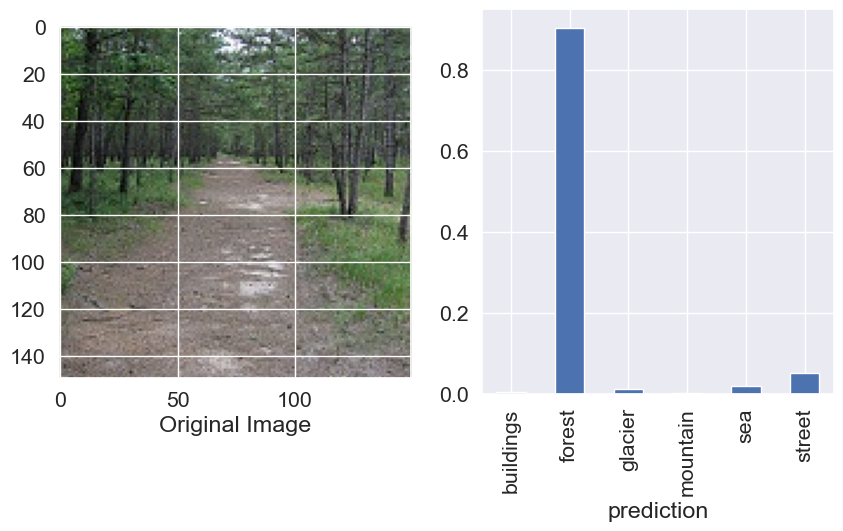

1/1 [==============================] - 0s 31ms/step


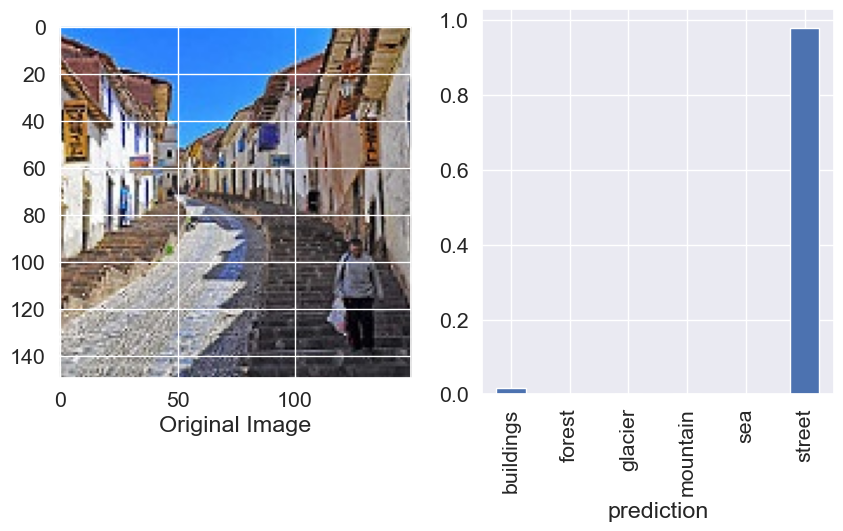

1/1 [==============================] - 0s 33ms/step


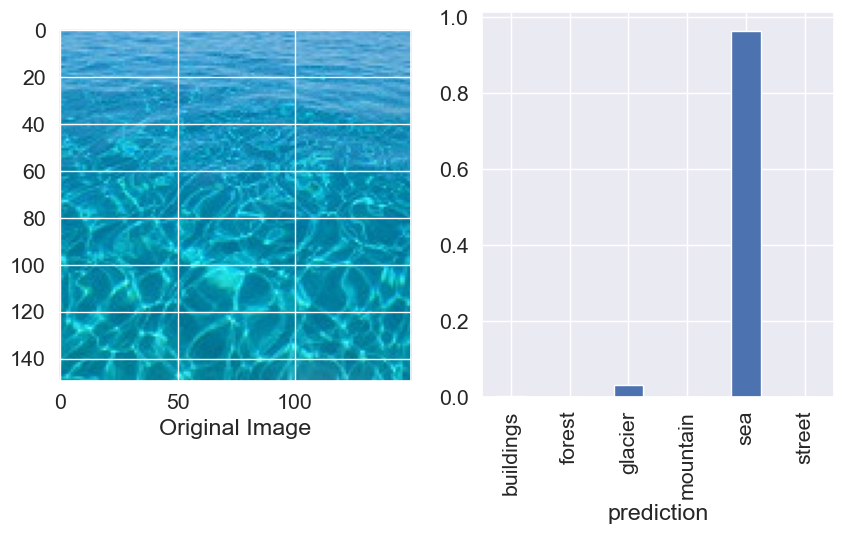

In [41]:
processing(seg_test_path + "/forest/20056.jpg")
processing(test_street_path + "/20297.jpg")
processing(test_sea_path + "//21259.jpg")

6.4.2 Our images

In [ ]:
sebbe_list = ['1','2','3','4','5','6','7','8','9']
for number in sebbe_list:
    processing(seg_our_path + f"//sebbe{number}.jpg")